In [1]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


#### Download packages if in Google Colab

In [2]:
colab_requirements = [
    "pip install tensorflow-gpu==2.0.0-beta0",
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

# Test noise reduction algorithm and view steps of algorithm

In [3]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load data

In [4]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))
data = data

In [5]:
IPython.display.Audio(data=data, rate=rate)

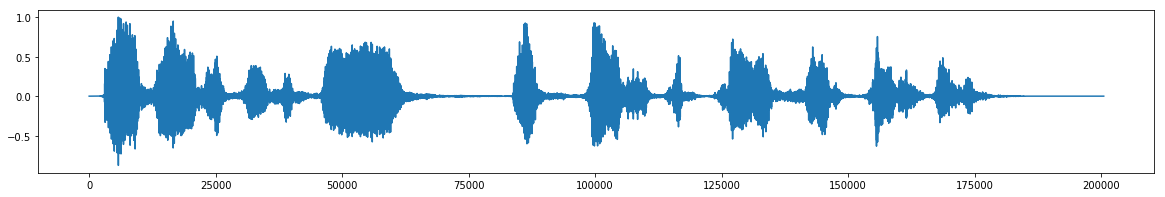

In [6]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

### add noise

In [7]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

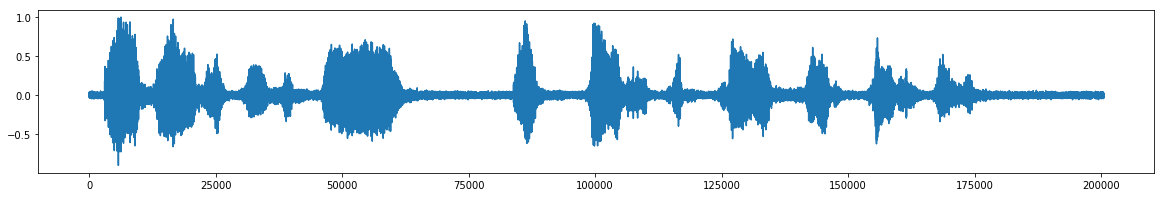

In [8]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [9]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

### remove noise

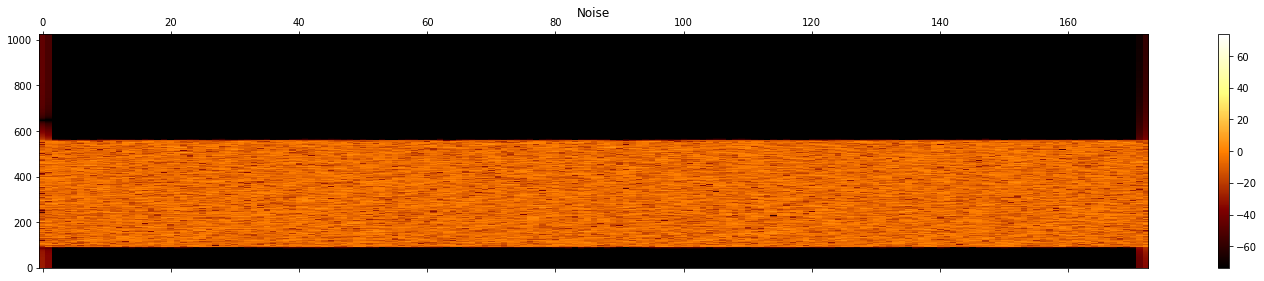

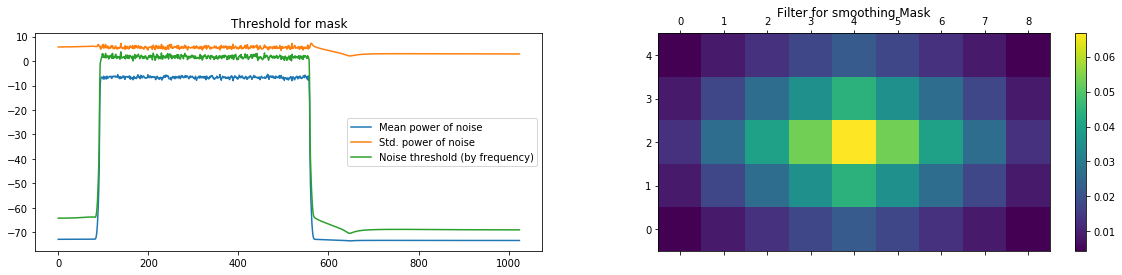

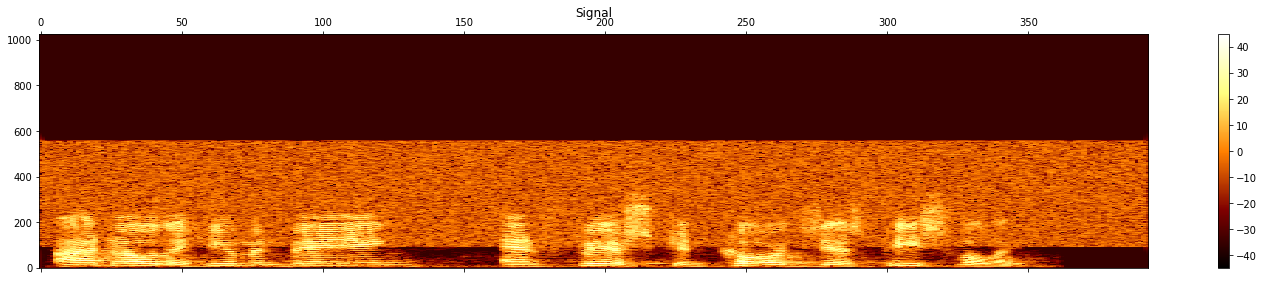

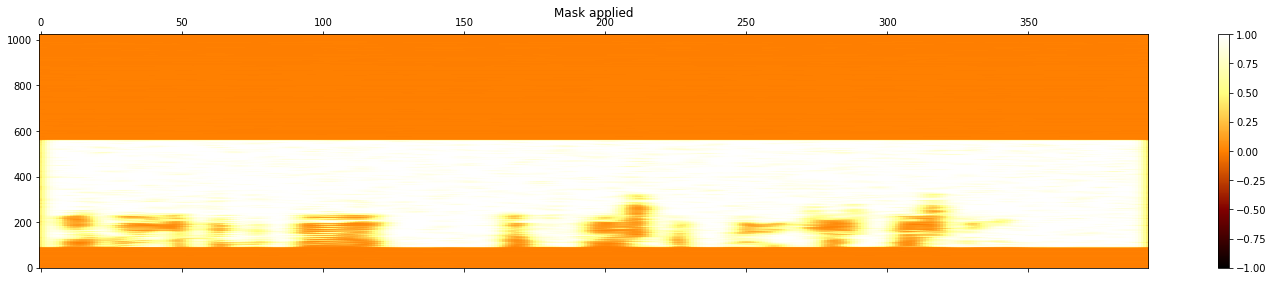

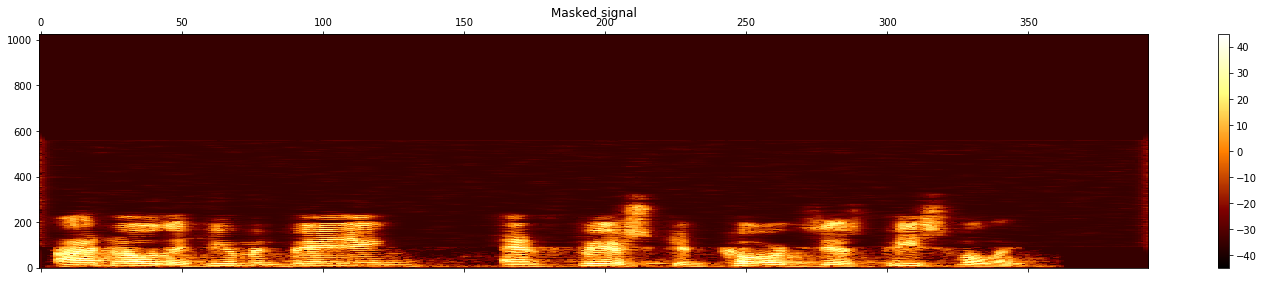

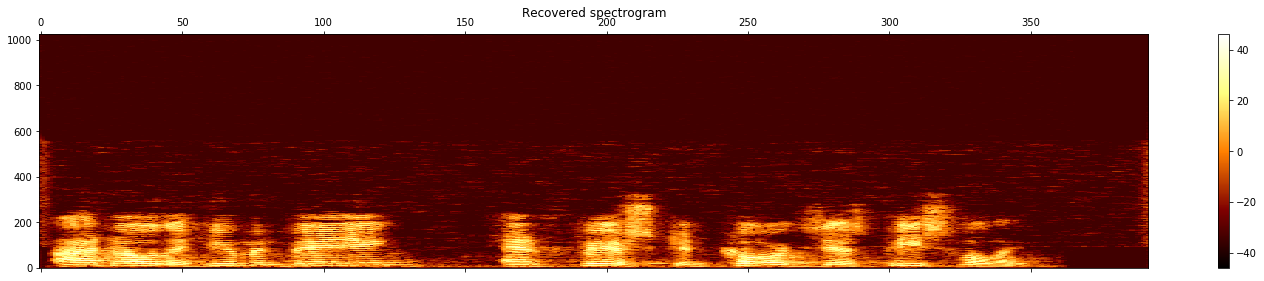

In [10]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip, verbose=True)

##### playback recovered audio

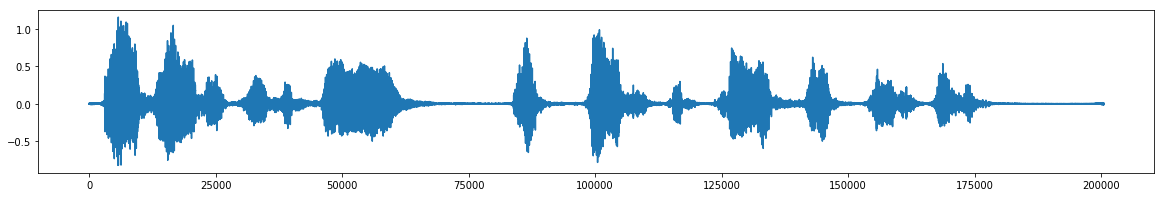

In [11]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced)

In [12]:
IPython.display.Audio(data=noise_reduced, rate=rate)

## A more difficult example 

In [13]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
response = urllib.request.urlopen(url)
noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

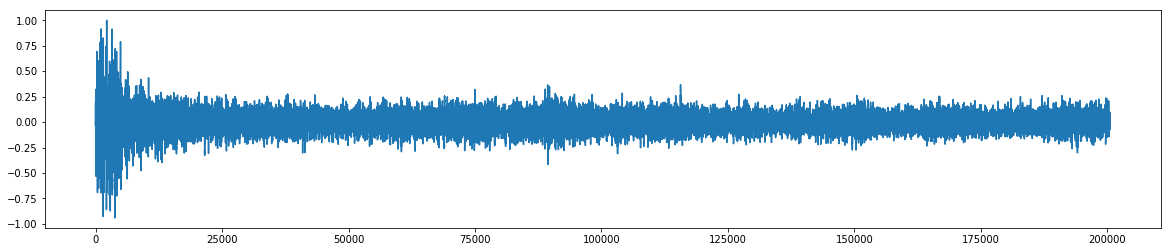

In [14]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

In [15]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

In [16]:
max(noise_data)

0.999969482421875

### add noise to data

In [17]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = data + noise_clip

### plot noisy data

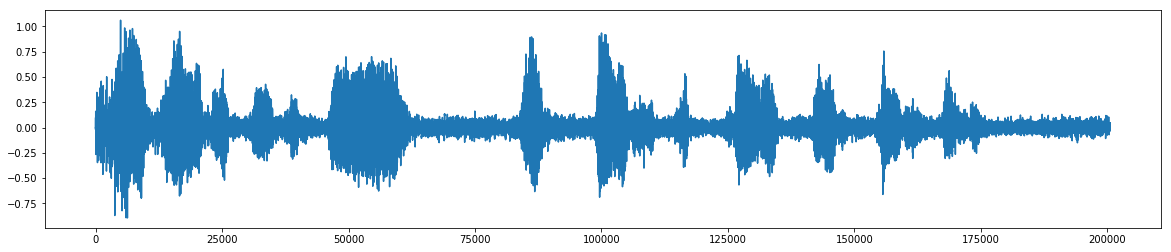

In [18]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)

IPython.display.Audio(data=audio_clip_cafe, rate=noise_rate)

### reduce noise

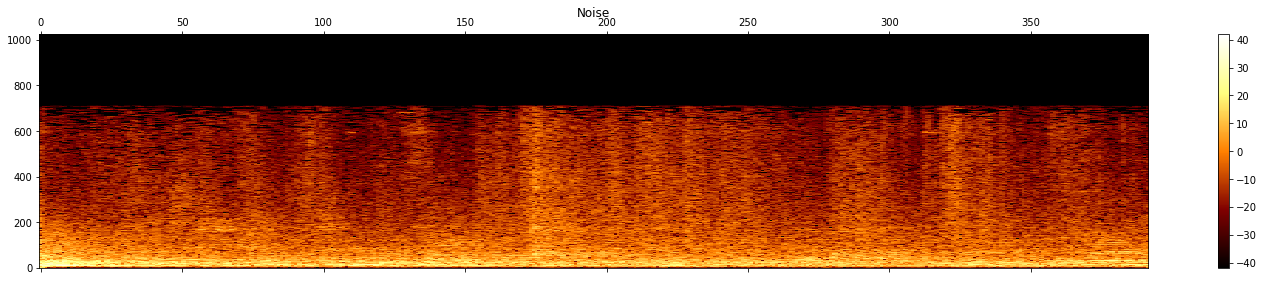

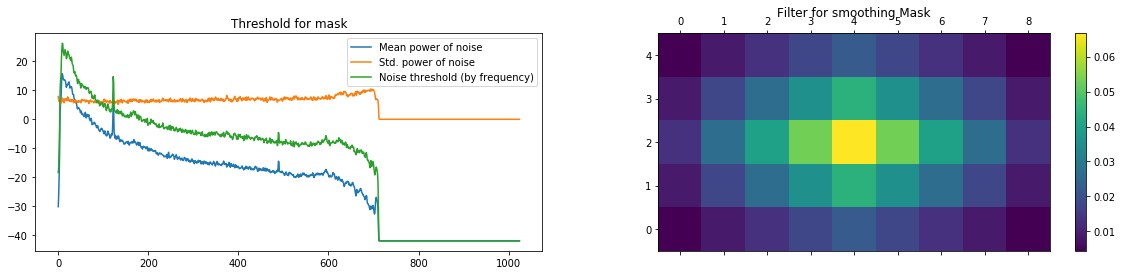

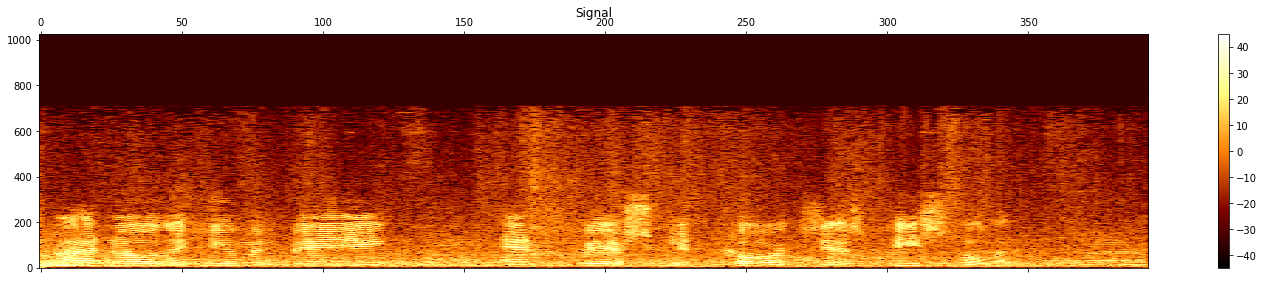

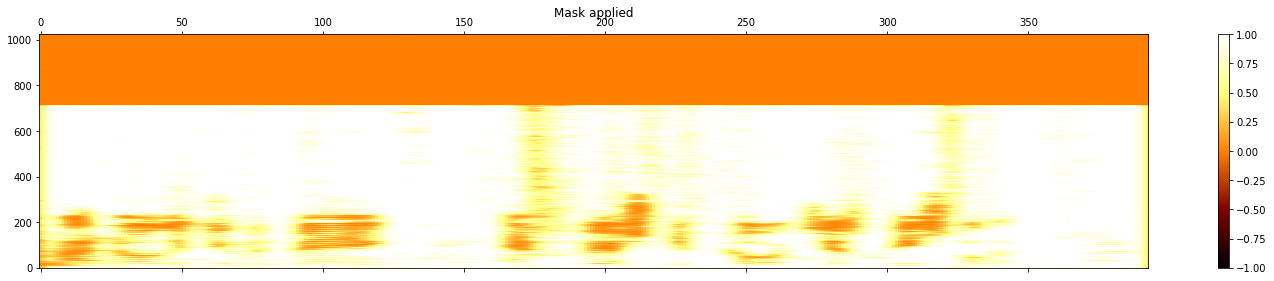

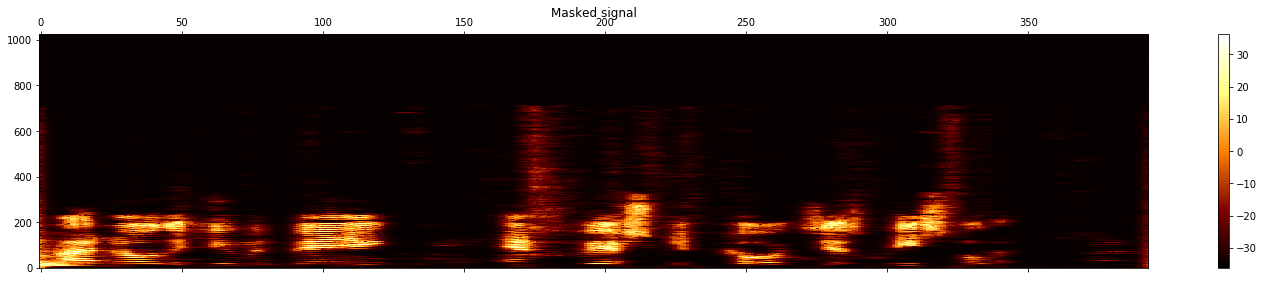

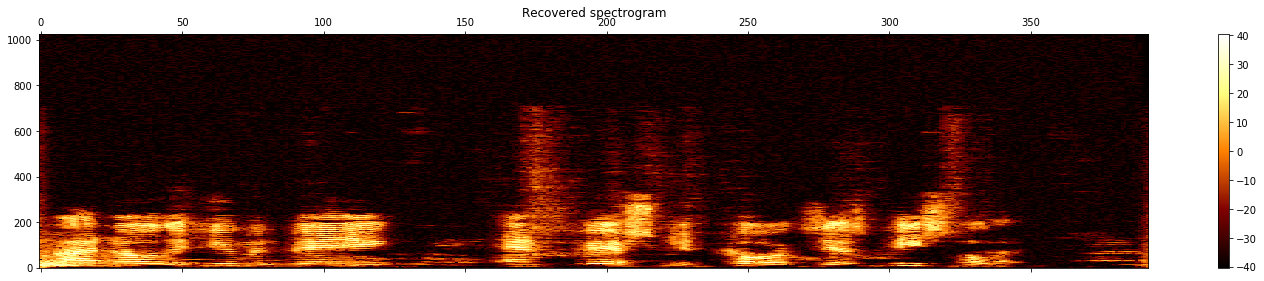

In [19]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe, noise_clip=noise_clip, verbose=True)

##### playback recovered audio

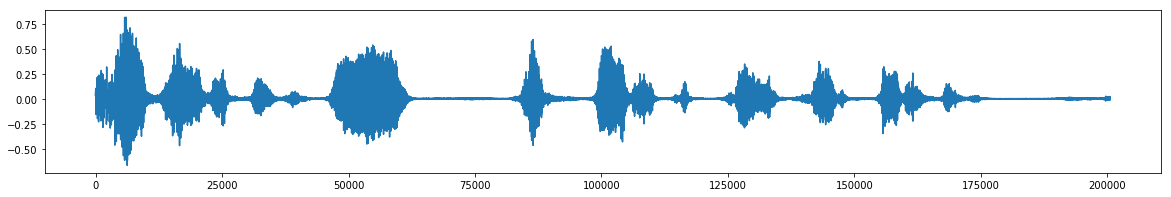

In [20]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced)

In [21]:
IPython.display.Audio(data=noise_reduced, rate=rate)

## Use tensorflow as the backend for noise reduction

In [22]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)

In [23]:
len(noise_reduced), len(audio_clip_cafe)

(200542, 200542)

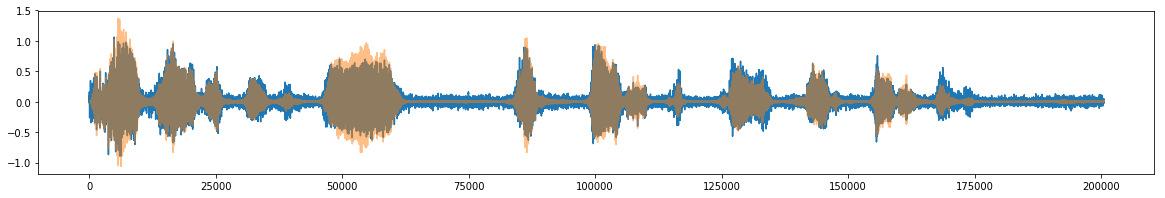

In [24]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(noise_reduced, alpha = 0.5)

In [25]:
IPython.display.Audio(data=noise_reduced, rate=rate)

### Compare times

In [26]:
%%timeit
# non-tensorflow
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=False, 
                                verbose=False)

177 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%%timeit
# Use tensorflow
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)

145 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### compare longer clips

In [28]:
# make a longer clip by repeating the same clip a few times
longer_clip = np.concatenate([audio_clip_cafe.astype('float32') for i in range(100)])
print("Clip is {} seconds long.".format(round(len(longer_clip)/rate)))

Clip is 455 seconds long.


In [29]:
%%time
# non-tensorflow
noise_reduced = nr.reduce_noise(audio_clip=longer_clip,
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=False, 
                                verbose=False)

CPU times: user 1min 16s, sys: 17.5 s, total: 1min 33s
Wall time: 22.7 s


In [30]:
%%time
# use tensorflow
noise_reduced = nr.reduce_noise(audio_clip=longer_clip,
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)

CPU times: user 53.5 s, sys: 10.9 s, total: 1min 4s
Wall time: 14.5 s
